# BDIA Project

In [1]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!mkdir generated_images
!mkdir generated_test_images
!mkdir gen_imgs
!mkdir saved_models


--2019-04-01 20:00:57--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  91.6MB/s    in 3.8s    

2019-04-01 20:01:01 (88.5 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

rm: cannot remove 'cell_images/Parasitized/Thumbs.db': No such file or directory


In [0]:
import zipfile
path_to_zip_file = "cell_images.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()

In [4]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
import tensorflow as tf
from keras.optimizers import Adam
from PIL import Image
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


## Viewing cell data

In [0]:
import os
import random
import matplotlib.pyplot as plt
input_directory = "cell_images"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
!rm cell_images/Parasitized/Thumbs.db

In [0]:


def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)
        



Uninfected


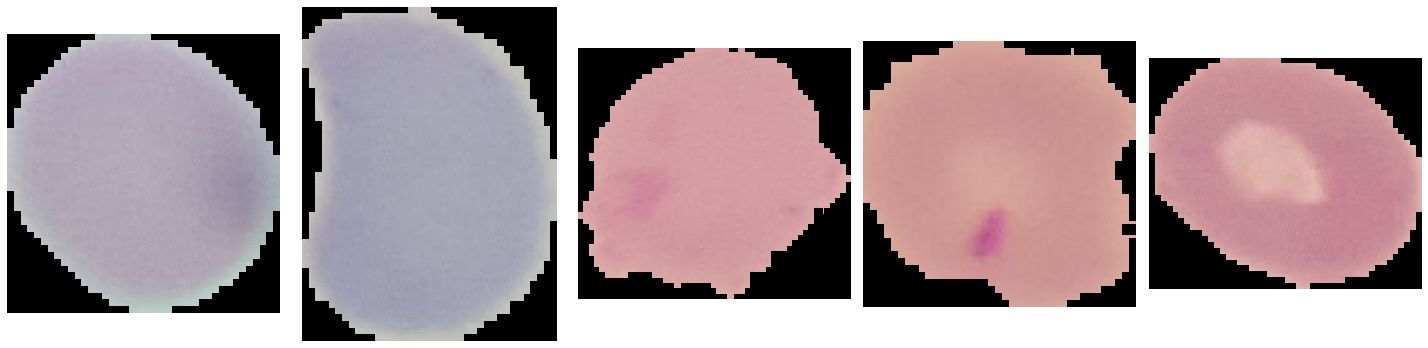

Parasitized


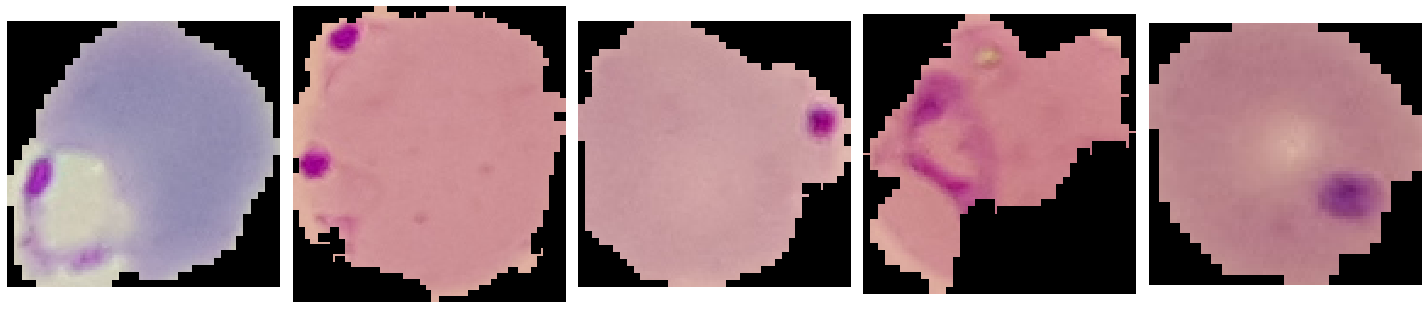

In [8]:
plot_img_dir_main(directory=training_dir, count=5)

## Building dataset

In [0]:
import os

# initialize the path to the original input directory of images
orig_input_dataset = "cell_images"

# initialize the base path to the new directory that will contain
# our images after computing the training and testing split
base_path = "output"

# derive the training, validation, and testing directories
train_path = os.path.sep.join([base_path, "training"])
val_path = os.path.sep.join([base_path, "validation"])
test_path = os.path.sep.join([base_path, "testing"])
 
# define the amount of data that will be used for training
train_split = 0.8
 
# the amount of validation data will be a percentage of the
# training data
val_split = 0.1

In [0]:
from imutils import paths # which you need to download! 
import random
import shutil
import os

# shuffle all the images in the original input directory 
imagePaths = list(paths.list_images(orig_input_dataset))
random.seed(42)
random.shuffle(imagePaths)

In [0]:
# split the data into testing and training 
i = int(len(imagePaths) * train_split)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# set aside some of the training data for validation data 
i = int(len(trainPaths) * val_split)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# define the training/validation/testing datasets 
datasets = [
	("training", trainPaths, train_path),
	("validation", valPaths, val_path),
	("testing", testPaths, test_path)
]

In [12]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating output/training' directory
[INFO] 'creating output/training/Uninfected' directory
[INFO] 'creating output/training/Parasitized' directory
[INFO] building 'validation' split
[INFO] 'creating output/validation' directory
[INFO] 'creating output/validation/Uninfected' directory
[INFO] 'creating output/validation/Parasitized' directory
[INFO] building 'testing' split
[INFO] 'creating output/testing' directory
[INFO] 'creating output/testing/Uninfected' directory
[INFO] 'creating output/testing/Parasitized' directory


In [0]:
# determine the # of image paths in training/validation/testing directories
totalTrain = len(list(paths.list_images(train_path)))
totalVal = len(list(paths.list_images(val_path)))
totalTest = len(list(paths.list_images(test_path)))

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")
 
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [15]:
BS = 32
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	train_path,
	class_mode="categorical",
	target_size=(64, 64),
	#color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	val_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	test_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


# Creating GAN [Generator and Discriminator]

In [0]:
def get_training_data(datafolder):
        print("Loading training data...")

        training_data = []
        #Finds all files in datafolder
        filenames = os.listdir(datafolder)
        for filename in tqdm(filenames):
            #Combines folder name and file name.
            path = os.path.join(datafolder,filename)
            #Opens an image as an Image object.
            image = Image.open(path)
            #Resizes to a desired size.
            image = image.resize((image_width,image_height),Image.ANTIALIAS)
            #Creates an array of pixel values from the image.
            pixel_array = np.asarray(image)

            training_data.append(pixel_array)

        #training_data is converted to a numpy array
        training_data = np.reshape(training_data,(-1,image_width,image_height,channels))
        return training_data

In [0]:
    def build_generator():
        #Generator attempts to fool discriminator by generating new images.
        model = Sequential()

        model.add(Dense(256*4*4,activation="relu",input_dim=random_noise_dimension))
        model.add(Reshape((4,4,256)))

        #Four layers of upsampling, convolution, batch normalization and activation.
        # 1. Upsampling: Input data is repeated. Default is (2,2). In that case a 4x4x256 array becomes an 8x8x256 array.
        # 2. Convolution: If you are not familiar, you should watch this video: https://www.youtube.com/watch?v=FTr3n7uBIuE
        # 3. Normalization normalizes outputs from convolution.
        # 4. Relu activation:  f(x) = max(0,x). If x < 0, then f(x) = 0.


        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))


        # Last convolutional layer outputs as many featuremaps as channels in the final image.
        model.add(Conv2D(channels,kernel_size=3,padding="same"))
        # tanh maps everything to a range between -1 and 1.
        model.add(Activation("tanh"))

        # show the summary of the model architecture
        model.summary()

        # Placeholder for the random noise input
        input = Input(shape=(random_noise_dimension,))
        #Model output
        generated_image = model(input)

        #Change the model type from Sequential to Model (functional API) More at: https://keras.io/models/model/.
        return Model(input,generated_image)


    def build_discriminator():
        #Discriminator attempts to classify real and generated images
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
        #Leaky relu is similar to usual relu. If x < 0 then f(x) = x * alpha, otherwise f(x) = x.
        model.add(LeakyReLU(alpha=0.2))

        #Dropout blocks some connections randomly. This help the model to generalize better.
        #0.25 means that every connection has a 25% chance of being blocked.
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        #Zero padding adds additional rows and columns to the image. Those rows and columns are made of zeros.
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        #Flatten layer flattens the output of the previous layer to a single dimension.
        model.add(Flatten())
        #Outputs a value between 0 and 1 that predicts whether image is real or generated. 0 = generated, 1 = real.
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        input_image = Input(shape=image_shape)

        #Model output given an image.
        validity = model(input_image)

        return Model(input_image, validity)

In [0]:
def train(datafolder ,epochs,batch_size,save_images_interval):
        #Get the real images
        training_data = get_training_data(datafolder)

        #Map all values to a range between -1 and 1.
        training_data = training_data / 127.5 - 1.

        #Two arrays of labels. Labels for real images: [1,1,1 ... 1,1,1], labels for generated images: [0,0,0 ... 0,0,0]
        labels_for_real_images = np.ones((batch_size,1))
        labels_for_generated_images = np.zeros((batch_size,1))

        for epoch in range(epochs):
            # Select a random half of images
            indices = np.random.randint(0,training_data.shape[0],batch_size)
            real_images = training_data[indices]

            #Generate random noise for a whole batch.
            random_noise = np.random.normal(0,1,(batch_size,random_noise_dimension))
            #Generate a batch of new images.
            generated_images = generator.predict(random_noise)

            #Train the discriminator on real images.
            discriminator_loss_real = discriminator.train_on_batch(real_images,labels_for_real_images)
            #Train the discriminator on generated images.
            discriminator_loss_generated = discriminator.train_on_batch(generated_images,labels_for_generated_images)
            #Calculate the average discriminator loss.
            discriminator_loss = 0.5 * np.add(discriminator_loss_real,discriminator_loss_generated)

            #Train the generator using the combined model. Generator tries to trick discriminator into mistaking generated images as real.
            generator_loss = combined.train_on_batch(random_noise,labels_for_real_images)
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))

            if epoch % save_images_interval == 0:
                save_images(epoch)
        generator.save("saved_models/facegenerator.h5")

        #Save the model for a later use


In [0]:
   def save_images(epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots(rows, columns)
        image_count = 0
        for row in range(rows):
            for column in range(columns):
                axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
                axis[row,column].axis('off')
                image_count += 1
        figure.savefig("generated_images/generated_%d.png" % epoch)
        plt.close()

In [0]:

def generate_single_image(model_path,image_save_path):
        noise = np.random.normal(0,1,(1,random_noise_dimension))
        model = load_model(model_path)
        generated_image = model.predict(noise)
        #Normalized (-1 to 1) pixel values to the real (0 to 256) pixel values.
        generated_image = (generated_image+1)*127.5
        print(generated_image)
        #Drop the batch dimension. From (1,w,h,c) to (w,h,c)
        generated_image = np.reshape(generated_image,image_shape)

        image = Image.fromarray(generated_image,"RGB")
        image.save(image_save_path)

In [21]:
image_width = 64
image_height = 64
channels = 3

image_shape = (image_width,image_height,channels)

#Amount of randomly generated numbers for the first layer of the generator.
random_noise_dimension = 100

#Just 10 times higher learning rate would result in generator loss being stuck at 0.
optimizer = Adam(0.0002,0.5)

discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
generator = build_generator()

#A placeholder for the generator input.
random_input = Input(shape=(random_noise_dimension,))

#Generator generates images from random noise.
generated_image = generator(random_input)

# For the combined model we will only train the generator
discriminator.trainable = False

#Discriminator attempts to determine if image is real or generated
validity = discriminator(generated_image)

#Combined model = generator and discriminator combined.
#1. Takes random noise as an input.
#2. Generates an image.
#3. Attempts to determine if image is real or generated.
combined = Model(random_input,validity)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1

In [22]:
train(datafolder="cell_images/Parasitized",epochs=1000, batch_size=32, save_images_interval=100)
generate_single_image("saved_models/facegenerator.h5","gen_imgs/test.png")

  0%|          | 46/13779 [00:00<00:30, 454.80it/s]

Loading training data...


100%|██████████| 13779/13779 [00:23<00:00, 577.95it/s]


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 2.053397, acc.: 31.25%] [Generator loss: 0.467431]
1 [Discriminator loss: 0.333104, acc.: 81.25%] [Generator loss: 3.337194]
2 [Discriminator loss: 0.123213, acc.: 98.44%] [Generator loss: 4.123508]
3 [Discriminator loss: 0.230388, acc.: 93.75%] [Generator loss: 4.781398]
4 [Discriminator loss: 0.252838, acc.: 93.75%] [Generator loss: 2.968746]
5 [Discriminator loss: 0.108960, acc.: 98.44%] [Generator loss: 2.768486]
6 [Discriminator loss: 0.175464, acc.: 98.44%] [Generator loss: 2.239692]
7 [Discriminator loss: 0.110211, acc.: 98.44%] [Generator loss: 2.551775]
8 [Discriminator loss: 0.134129, acc.: 96.88%] [Generator loss: 4.825868]
9 [Discriminator loss: 0.471714, acc.: 73.44%] [Generator loss: 4.040041]
10 [Discriminator loss: 0.081041, acc.: 98.44%] [Generator loss: 5.168773]
11 [Discriminator loss: 0.066637, acc.: 98.44%] [Generator loss: 5.061863]
12 [Discriminator loss: 0.512205, acc.: 79.69%] [Generator loss: 8.638627]
13 [Discriminator loss: 0.384020, a

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[[[[1.5905946e-02 2.9972792e-02 2.1172464e-02]
   [6.8396330e-05 2.2798777e-04 6.0036778e-04]
   [2.2798777e-05 3.7997961e-05 8.3595514e-05]
   ...
   [0.0000000e+00 2.2798777e-05 7.5995922e-06]
   [1.6719103e-04 8.1315637e-04 4.7117472e-04]
   [3.1918287e-04 8.3367527e-03 7.9491735e-03]]

  [[1.0639429e-04 5.3197145e-04 1.3679266e-04]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 7.5995922e-06]
   [0.0000000e+00 0.0000000e+00 1.5199184e-05]]

  [[0.0000000e+00 2.2798777e-05 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

  ...

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.000000

## Generate test set from trained GAN

In [0]:
from keras.models import load_model
from keras import backend as K
def save_test_images(epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 2, 2
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        saved_model_path = 'saved_models/facegenerator.h5'
        generator = load_model(saved_model_path)
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots(rows, columns)
        image_count = 0
        for row in range(rows):
            for column in range(columns):
                axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
                axis[row,column].axis('off')
                image_count += 1
        figure.savefig("generated_test_images/generated_%d.png" % epoch)
        plt.close()


In [0]:
for i in range(0,3):
  print("Saving image "+str(i))
  save_test_images(i)

In [0]:
def save_test_images_one(epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 2, 2
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        saved_model_path = 'saved_models/facegenerator.h5'
        generator = load_model(saved_model_path)
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots()
        image_count = 0
        
        axis.imshow(generated_images[1, :], cmap='spring')
        axis.axis('off')
        figure.savefig("generated_test_images/generated_%d.png" % epoch)
        plt.close()


In [50]:
for i in range(0,3):
  print("Saving image "+str(i))
  save_test_images_one(i)

Saving image 0


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Saving image 1
Saving image 2
